In [3]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    

/kaggle/input/england-regions1/ENGLAND_REGIONS.geojson
/kaggle/input/uk-housing-prices-paid/price_paid_records.csv


# England House Price Average 1999 by Region



## Objective:

This task focused notebook follows on from [England House Price Analysis]().

England is divided into nine administrative regions: South West, South East, London, West Midlands, East Midlands, Yorkshire and The Humber, East of England, North West and North East.

The task is to create an straightforward, accessible visualisation of average house price in England 1999 by region.

### Challenges:

- This dataframe is huge, so creating this visual in kaggle will require a smaller dataframe

- The dataframe doesn't have a column for Region, only county.

- The dataframe doesn't have any coordinates for longitude or latitude.

- There are no inbuilt functions for a map of English Regions in geopandas or plotly.

### Solutions:

- To save memory, I will overwrite the imported dataframe instead of naming new ones and remove all unwanted columns.

- I will write a function to assign each county to a region and then apply this to a new column.

- I will merge the dataframe and the map file based on a common value, 'Region'.

-  I have find an accurate and open source map of English regions as a geojson file and import it.


### About The Data:

- The data used is a csv file from [Kaggle](https://www.kaggle.com/datasets/hm-land-registry/uk-housing-prices-paid), the data is sourced from HM Land Registry and was released under Open Government License 3.0. This is a large dataset, containing Price Paid data for England and Wales between 1995 and 2017.

- The map used is a geojson file downloaded from the [Open Geography Portal](https://geoportal.statistics.gov.uk/datasets/7c23fbe8e89d4cf79ff7f2a6058e6200_0/explore) on the Office for National Statistics website, also available under Open Government License 3.0.

In [44]:
#import packages and data
import pandas as pd
import json
import geopandas as gpd
import matplotlib.pyplot as pltx

df = pd.read_csv(r'/kaggle/input/uk-housing-prices-paid/price_paid_records.csv')
GEOJSON_FILE = '/kaggle/input/england-regions1/ENGLAND_REGIONS.geojson'

In [45]:
df1=df.copy()

In [25]:
#Checking the data has loaded correctly
df1.head()


,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18 00:00,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,A
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09 00:00,S,N,F,GRAYS,THURROCK,THURROCK,A,A
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30 00:00,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,A
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24 00:00,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,A
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23 00:00,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,A


In [6]:
#Drop columns as they are not relevant this time
columns_to_drop= ['Transaction unique identifier', 'Old/New', 'Duration','Town/City', 'District', 'PPDCategory Type', 'Record Status - monthly file only', 'Record Status - monthly file only']
df1=df1.drop(columns=columns_to_drop)
#Drop Property Type 0 as it is not relevant
df1 = df1[df1['Property Type'] != 'O']


In [26]:
#Convert the 'Date of transfer' column to a pandas datetime type
df1['Date of Transfer'] = pd.to_datetime(df1['Date of Transfer'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22489348 entries, 0 to 22489347
Data columns (total 11 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   Transaction unique identifier      object        
 1   Price                              int64         
 2   Date of Transfer                   datetime64[ns]
 3   Property Type                      object        
 4   Old/New                            object        
 5   Duration                           object        
 6   Town/City                          object        
 7   District                           object        
 8   County                             object        
 9   PPDCategory Type                   object        
 10  Record Status - monthly file only  object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 1.8+ GB


In [32]:
#Create a numerical column for year of transfer
df1['Year of Transfer'] = pd.to_datetime(df1['Date of Transfer']).dt.year
#Create a numerical column for month of transfer
df1['Month of Transfer'] = pd.to_datetime(df1['Date of Transfer']).dt.month

In [33]:
#Define a function to assign each County to one of the 9 administrative Regions of England or (can easily be updated) Wales:
def find_region(x):
    
    if x == 'CORNWALL' or x=='SOMERSET' or x== 'AVON' or x=='BOURNEMOUTH' or x=='GLOUCESTERSHIRE' or x=='DORSET' or x== 'DEVON' or x== 'ISLES OF SCILLY' or x=='SOUTH GLOUCESTERSHIRE' or x=='NORTH SOMERSET' or x=='CITY OF BRISTOL' or x=='TORBAY' or x=='BATH AND NORTH EAST SOMERSET' or x=='POOLE' or x=='THAMESDOWN'or x== 'WILTSHIRE' or x== 'CITY OF PLYMOUTH' or x=='SWINDON':
        return 'South West'
    
    elif x == 'WEST MIDLANDS' or  x=='STOKE-ON-TRENT' or x=='SHROPSHIRE' or x=='HEREFORDSHIRE'or x=='HEREFORD AND WORCESTER' or x=='WORCESTERSHIRE' or x=='STAFFORDSHIRE' or x=='WREKIN' or x=='WARWICKSHIRE':
        return 'West Midlands'
    
    elif x == 'GREATER LONDON':
        return 'London'
    
    elif x == 'KENT' or x=='ISLE OF WIGHT' or x=='PORTSMOUTH' or x=='MEDWAY' or x=='OXFORDSHIRE' or x=='SOUTHAMPTON' or x=='WEST BERKSHIRE' or x=='BRIGHTON AND HOVE' or x=='BERKSHIRE' or x=='SLOUGH' or x=='HAMPSHIRE' or x=='WOKINGHAM' or x=='READING' or x=='WINDSOR AND MAIDENHEAD' or x== 'BRACKNELL FOREST' or x=='MILTON KEYNES' or x=='SURREY' or x=='BUCKINGHAMSHIRE' or x=='WEST SUSSEX' or x=='EAST SUSSEX':
        return 'South East'
    
    elif x == 'YORK' or x=='NORTH YORKSHIRE' or x=='WEST YORKSHIRE' or x=='SOUTH YORKSHIRE' or x=='EAST RIDING OF YORKSHIRE' or x== 'NORTH EAST LINCOLNSHIRE' or x=='CITY OF KINGSTON UPON HULL'or x=='NORTH LINCOLNSHIRE' or x=='NORTH EAST LINCOLNSHIRE' or x=='HUMBERSIDE':
        return 'Yorkshire and The Humber'
    
    elif x == 'CUMBRIA' or x=='BLACKPOOL' or x=='GREATER MANCHESTER' or x=='MERSEYSIDE' or x=='LANCASHIRE' or x=='WARRINGTON' or x=='CHESHIRE' or x=='HALTON' or x=='CHESHIRE WEST AND CHESTER' or x=='BLACKBURN WITH DARWEN' or x=='CHESHIRE EAST':
        return 'North West'

    elif x == 'TYNE AND WEAR' or x=='DARLINGTON' or x=='HARTLEPOOL' or x=='COUNTY DURHAM' or x=='NORTHUMBERLAND' or x=='DURHAM' or x=='REDCAR AND CLEVELAND' or x=='STOCKTON-ON-TEES' or x=='MIDDLESBROUGH' or x=='CLEVELAND':
        return 'North East'
    
    elif x == 'NORFOLK' or x=='THURROCK' or x=='BEDFORDSHIRE' or x=='CITY OF PETERBOROUGH'or x=='CAMBRIDGESHIRE' or x=='LUTON' or x=='CENTRAL BEDFORDSHIRE' or x=='BEDFORD'or x=='SOUTHEND-ON-SEA' or x=='ESSEX' or x=='NORTHAMPTONSHIRE' or x=='HERTFORDSHIRE'or x=='NORFOLK' or x=='SUFFOLK':
        return 'East of England'
    
    elif x == 'DERBYSHIRE' or x=='LEICESTER' or x=='RUTLAND' or x=='LINCOLNSHIRE' or x=='CITY OF NOTTINGHAM' or x=='CITY OF DERBY' or x=='NOTTINGHAMSHIRE' or x=='LEICESTERSHIRE':
        return 'East Midlands'
    
    else:
        return 'Wales'
   
#Apply this function to the County column, creating a new column called Region'
df1['Region'] =df1['County'].apply(find_region)

In [34]:
#Removing Wales as this will not appear in the visualisation
df1= df1[df1['Region'] != "Wales"]


In [35]:
#Remove all rows where year was not 1999
df1= df1[df1['Year of Transfer']== 1999]

In [38]:
#create a smaller dataframe, containing month (useful if I decide to add a slider), region and average price.
#calculated the average price paid for each region, grouped the data and reset the index.
av_price_df = df1.groupby(['Region', 'Month of Transfer'])['Price'].mean().reset_index()

In [46]:
#rename the colum region to RGN23NM, this is the same key for region as in the geojson file
av_price_df = av_price_df.rename(columns={'Region': 'RGN23NM', 'Price': 'Average Price'})
av_price_df.head()

,RGN23NM,Month of Transfer,Average Price
0,East Midlands,1,61609.566539
1,East Midlands,2,62018.361781
2,East Midlands,3,64338.312973
3,East Midlands,4,65771.998136
4,East Midlands,5,65510.426247


In [41]:
#merge the dataframe with the geojson file on the key in common, left on RGN23NM which contains the region
merged_data = geojson.merge(av_price_df, how='left', on='RGN23NM')
#check changes have been applied
merged_data.head()

,FID,RGN23CD,RGN23NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,Month of Transfer,Average Price
0,1,E12000001,North East,417314,600356,-1.72888,55.29701,0f3c8c9a-179f-492c-9d08-d3cce8102e95,"MULTIPOLYGON (((429303.500 604980.795, 429297....",1,54361.406449
1,1,E12000001,North East,417314,600356,-1.72888,55.29701,0f3c8c9a-179f-492c-9d08-d3cce8102e95,"MULTIPOLYGON (((429303.500 604980.795, 429297....",2,55377.817009
2,1,E12000001,North East,417314,600356,-1.72888,55.29701,0f3c8c9a-179f-492c-9d08-d3cce8102e95,"MULTIPOLYGON (((429303.500 604980.795, 429297....",3,56272.051486
3,1,E12000001,North East,417314,600356,-1.72888,55.29701,0f3c8c9a-179f-492c-9d08-d3cce8102e95,"MULTIPOLYGON (((429303.500 604980.795, 429297....",4,57493.310354
4,1,E12000001,North East,417314,600356,-1.72888,55.29701,0f3c8c9a-179f-492c-9d08-d3cce8102e95,"MULTIPOLYGON (((429303.500 604980.795, 429297....",5,57480.572184


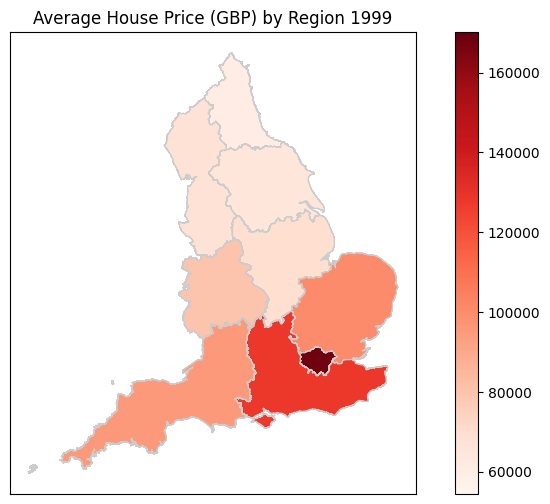

In [43]:

#Set the figure size
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
#plot the data from the merged dataframe, using 'Reds' colourmap, including a legend which will show the price paid
merged_data.plot(column='Average Price', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

#Add a title
ax.set_title('Average House Price (GBP) by Region 1999')
#Remove axis tickers as they had no purpose
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Conclusion

The map above fits the brief. Not only is it visually appealing, but it is also a straightforward, accessible visualisation of average house price in England 1999 by region.

To save memory, I overwrote the copy of the dataframe instead of naming new ones, and I removed all unwanted columns. 

I added the region to each row by writing a function to assign each county to a region,  then applying this to a new column.

To connect the average price paid dataframe to the geojson file, I was able to merge the dataframe and the map file based on a common key, Region/RGN23NM.

I overcame the lack of inbuilt map by finding and importing an accurate and open source map of English regions as a geojson file.

Overall the resulting visualisation is a success and the code could easily be used to reproduce the visualisation for different years.

## Reflection

In order to improve this visualisation, I could add a slider for months.